In [1]:
# Install packages

# noinspection PyUnresolvedReferences
import matplotlib as mp
# noinspection PyUnresolvedReferences
from matplotlib import pyplot as plt
# noinspection PyUnresolvedReferences
from pyspark.sql import *
# noinspection PyUnresolvedReferences
from pyspark.sql import SparkSession
# noinspection PyUnresolvedReferences
from pyspark.sql.functions import explode
# noinspection PyUnresolvedReferences
from pyspark.sql import functions as F
# noinspection PyUnresolvedReferences
from pyspark.sql.types import IntegerType
# noinspection PyUnresolvedReferences
from pyspark.sql.functions import hour, mean, count, minute, second, date_format, col, explode, to_timestamp
from pyspark.sql.functions import *
# noinspection PyUnresolvedReferences
from pyspark.sql.window import Window
# noinspection PyUnresolvedReferences
import seaborn as sns
# noinspection PyUnresolvedReferences
import io 
# noinspection PyUnresolvedReferences
import datetime as dt
# noinspection PyUnresolvedReferences
import matplotlib.dates as md
# noinspection PyUnresolvedReferences
import sys
# noinspection PyUnresolvedReferences
import pickle 
# noinspection PyUnresolvedReferences
import statsmodels.api as sm
# noinspection PyUnresolvedReferences
import statsmodels.formula.api as smf 
# noinspection PyUnresolvedReferences
import pandas as pd
# noinspection PyUnresolvedReferences
import numpy as np

In [2]:
pip install textblob

  Using cached textblob-0.15.3-py2.py3-none-any.whl (636 kB)
Processing /home/jovyan/.cache/pip/wheels/45/6c/46/a1865e7ba706b3817f5d1b2ff7ce8996aabdd0d03d47ba0266/nltk-3.5-py3-none-any.whl
  Using cached regex-2020.4.4-cp37-cp37m-manylinux2010_x86_64.whl (679 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import textblob as tb

In [4]:
pip install wordcloud

  Using cached wordcloud-1.6.0-cp37-cp37m-manylinux1_x86_64.whl (361 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
from wordcloud import WordCloud, STOPWORDS

In [6]:
##### Initialize Spark Session & Context #####
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [7]:
# Create Spark DataFrame & display first 10 rows
tweet_raw = (spark.read.format("csv").options(header="true").load("20200312_Coronavirus_Tweets_Subset.CSV"))
display(tweet_raw)

DataFrame[_c0: string, status_id: string, user_id: string, created_at: string, screen_name: string, text: string, source: string, reply_to_status_id: string, reply_to_user_id: string, reply_to_screen_name: string, is_quote: string, is_retweet: string, favourites_count: string, retweet_count: string, country_code: string, place_full_name: string, place_type: string, followers_count: string, friends_count: string, account_lang: string, account_created_at: string, verified: string, lang: string]

In [8]:
#### CLEAN DATA ####
# Initially filter tweets in English & create new filtered DataFrame
tweet_filter = tweet_raw.select("*", F.when(tweet_raw.lang == 'en', 'TRUE').alias('eng_true'))
tweet_filter = tweet_filter.filter("eng_true == 'TRUE'")
# Fix Date Structure
tweet_filter = tweet_filter.withColumn('created_at', regexp_replace('created_at', 'T', ' '))
tweet_filter = tweet_filter.withColumn('created_at', regexp_replace('created_at', 'Z', ''))
# Convert to Timestamp
tweet_filter = tweet_filter.withColumn('created_at',to_timestamp(tweet_filter.created_at, 'yyyy-MM-dd HH:mm:ss'))
# Drop Unused Columns
tweet_filter = tweet_filter.drop('reply_to_status_id','reply_to_user_id','reply_to_screen_name','place_type','account_lang')
# Define Columns for Integer Transformation
cols = spark.createDataFrame([('status_id',1),('user_id',2),('favourites_count',3),('retweet_count',4),('followers_count',5),('friends_count',6)])
cols_col = cols.select("_1")
colnames = cols_col.rdd.map(lambda row : row[0]).collect()
# Transform Columns to Integer Type
for colname in colnames:
    tweet_filter = tweet_filter.withColumn(colname, tweet_filter[colname].cast(IntegerType()))
tweet_filter

DataFrame[_c0: string, status_id: int, user_id: int, created_at: timestamp, screen_name: string, text: string, source: string, is_quote: string, is_retweet: string, favourites_count: int, retweet_count: int, country_code: string, place_full_name: string, followers_count: int, friends_count: int, account_created_at: string, verified: string, lang: string, eng_true: string]

In [9]:
##### Tweet Sentiment Analysis
# Create simple tweet sentiment analysis using TextBlob

positive = 0
negative = 0
neutral = 0
polarity = 0


def percent_calc(a, b):
    return 100 * float(a) / float(b)

# Isolate tweets column for sentiment analysis
tweets_col = tweet_filter.select("text")
tweets = tweets_col.rdd.map(lambda row : row[0]).collect()
n_tweets = len(tweets_col.rdd.map(lambda row : row[0]).collect())

for tweet in tweets:
    print(tweet)
    myAnalysis = tb.TextBlob(tweet)
    polarity += myAnalysis.sentiment.polarity
    if myAnalysis.sentiment.polarity == 0:
        neutral += 1
    elif myAnalysis.sentiment.polarity > 0.00:
        positive += 1
    elif myAnalysis.sentiment.polarity < 0.00:
        negative += 1
        


Watch this newly released video featuring a message from Tokyo's Governor Koike on #COVID19 below #Coronavirus https://t.co/V9b5wITADF
This JAMA Insights article reviews care for the most severely ill patients with #coronavirus disease 2019 (#COVID19), including standards of management of #ARDS, preventing #SARSCoV2 spread in health care settings, and surge preparation https://t.co/wh8M3aDplb
Today in the entertainment industry, late-night TV will drop live audiences, and the E3 gaming convention was canceled due to the #COVID19 outbreak. More updates:  https://t.co/I9X4r1e4IX
To help those in the foodservice and restaurant industry monitor, prevent and respond to a potential spread of #coronavirus, we’ve compiled a list of reliable resources available online. #PartsTownTips #COVID19 #blog #PartsTown
No, but seriously, #WhereAreTheTestKits? #COVID19
Tonight: Wednesday, March 11, join us for our latest #coronavirus public mtg w local hospitals &amp; school districts. 6pm at Monterey Hig

In [10]:
positive = percent_calc(positive, n_tweets)
negative = percent_calc(negative, n_tweets)
neutral = percent_calc(neutral, n_tweets)

positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')


if polarity > 0:
    print('----------------------------------------------------------------------------')
elif polarity < 0:
    print('Negative')
elif polarity == 0:
    print('Neutral')

----------------------------------------------------------------------------


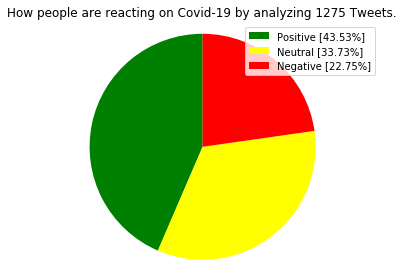

In [11]:
# Plot results

labels = ['Positive [' + str(positive) + '%]', 'Neutral [' + str(neutral) + '%]','Negative [' + str(negative) + '%]']
sizes = [positive, neutral, negative]
colors = ['green', 'yellow', 'red']
patches, texts = plt.pie(sizes, colors = colors, startangle = 90)
plt.legend(patches, labels, loc = "best")
plt.title('How people are reacting on ' + 'Covid-19' + ' by analyzing ' + str(n_tweets) + ' Tweets.')
plt.axis('equal')
plt.tight_layout()
plt.show()

<Figure size 720x720 with 0 Axes>

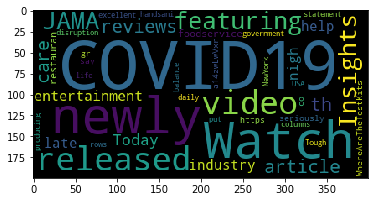

<Figure size 720x720 with 0 Axes>

In [12]:
######## WordClouds ########
#CONVERTING TWEETS FOR WORDCLOUD
marchtext=pd.DataFrame(tweets)
text=str(marchtext)

#CREATE AND RUN WORDCLOUD
stopwords=set(STOPWORDS)
wordcloud=WordCloud(stopwords=stopwords).generate(text)

plt.imshow(wordcloud)
plt.figure(figsize = (10, 10), facecolor = None) 

In [13]:
#### Simple KPIs ####
# Hourly Tweet Count
hourlyCount = (tweet_filter.groupBy(hour("created_at").alias("hour")).agg(count("text").alias("count")).sort(desc("hour")).show())

# Quote Count
QuoteCount = (tweet_filter.groupBy("is_quote").agg(count("text").alias("count")).sort(desc("is_quote")).show())

# Retweet Count
RetweetCount = (tweet_filter.groupBy("is_retweet").agg(count("text").alias("count")).sort(desc("is_retweet")).show())

# Mean Follower Count
FollowerCount = (tweet_filter.agg(mean("followers_count").alias("mean"))).show()

+----+-----+
|hour|count|
+----+-----+
|   0| 1275|
+----+-----+

+--------+-----+
|is_quote|count|
+--------+-----+
|    TRUE|  228|
|   FALSE| 1047|
+--------+-----+

+----------+-----+
|is_retweet|count|
+----------+-----+
|     FALSE| 1275|
+----------+-----+

+-----------------+
|             mean|
+-----------------+
|40620.39921568627|
+-----------------+



In [14]:
#Drop NA/Null values in country code column
tweet_raw2 = tweet_filter.na.drop(subset=["country_code"])

tweet_raw2.groupBy("country_code") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+------------+-----+
|country_code|count|
+------------+-----+
|          US|   66|
|          CA|    8|
|          PH|    3|
|          NZ|    2|
|          AT|    1|
|          LB|    1|
|          AU|    1|
|          CH|    1|
|          MY|    1|
|          GB|    1|
|          BE|    1|
|          JM|    1|
|          GR|    1|
+------------+-----+



In [15]:
# Plot the histogram of langauge that related to Coronavirus
# tweet_raw2.groupby('Lang').count().select('count').rdd.flatMap(lambda x: x).histogram(10)

In [16]:
# Count number of verified accounts
tweet_raw2.groupBy("verified") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+--------+-----+
|verified|count|
+--------+-----+
|   FALSE|   79|
|    TRUE|    9|
+--------+-----+



In [18]:
#Drop NA/Null values in langauge column
tweet_raw3 = tweet_filter.na.drop(subset=["source"])

tweet_raw3.groupBy("source") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+--------------------+-----+
|              source|count|
+--------------------+-----+
|  Twitter for iPhone|  615|
|     Twitter Web App|  261|
| Twitter for Android|  214|
|           TweetDeck|   47|
|    Twitter for iPad|   42|
|  Twitter Web Client|   21|
|      Hootsuite Inc.|   14|
|tiorradio2 publisher|    8|
|           Instagram|    5|
|tiorradio1 publisher|    5|
|tiorradio3 publisher|    4|
|              Buffer|    4|
|    Tweetbot for iΟS|    4|
|          SocialFlow|    3|
|             HubSpot|    3|
|       Sprout Social|    2|
|             Echofon|    2|
|    Tweetbot for Mac|    2|
|      SocialNewsDesk|    2|
|Twitter Media Studio|    1|
+--------------------+-----+
only showing top 20 rows



In [19]:
# Plot the histogram of verified accounts
# tweet_raw.groupby('source').count().select('count').rdd.flatMap(lambda x: x).histogram(10)

In [20]:
# Top10 Languages used by Tweets
spark = SparkSession \
    .builder \
    .appName("Twitter Data Analysis") \
    .getOrCreate()
df = tweet_filter
df.createOrReplaceTempView("BtsCovSpo")
sqlDF = spark.sql("select count(*) as Total_count, lang as Language from BtsCovSpo group by lang order by Total_count desc limit 11")
pd = sqlDF.toPandas()


def plot12():
    #plt.title('Top10 Languages used by Tweets')
    #sns.pointplot(y="Total_count", x="Language",data=pd)
    pd.plot.line(x="Language", y="Total_count", title="Top10 Languages used by Tweets")
    bytes_image = io.BytesIO()
    # plt.savefig('foo.png')
    plt.savefig(bytes_image, format='png')
    bytes_image.seek(0)
    return bytes_image

In [21]:
# Time series analysis
tweets_pdf = tweet_filter.toPandas()
tweets_pdf.head(10)

tweet_filter = tweet_filter.withColumn('month',F.month(F.to_timestamp('created_at', 'dd/MM/yyyy')))

In [22]:
# Count number of tweets in each month

tweet_filter.groupBy('month').count().show()

tweet_filter2 = tweet_filter.select('created_at', date_format('created_at', 'u').alias('dow_number'), date_format('created_at', 'E').alias('dow_string'))
tweet_filter2.show()

# Count number of tweets each day of the week

tweet_filter2.groupBy('dow_string').count().show()

+-----+-----+
|month|count|
+-----+-----+
|    3| 1275|
+-----+-----+

+-------------------+----------+----------+
|         created_at|dow_number|dow_string|
+-------------------+----------+----------+
|2020-03-12 00:00:00|         4|       Thu|
|2020-03-12 00:00:00|         4|       Thu|
|2020-03-12 00:00:00|         4|       Thu|
|2020-03-12 00:00:00|         4|       Thu|
|2020-03-12 00:00:00|         4|       Thu|
|2020-03-12 00:00:00|         4|       Thu|
|2020-03-12 00:00:01|         4|       Thu|
|2020-03-12 00:00:01|         4|       Thu|
|2020-03-12 00:00:01|         4|       Thu|
|2020-03-12 00:00:01|         4|       Thu|
|2020-03-12 00:00:02|         4|       Thu|
|2020-03-12 00:00:05|         4|       Thu|
|2020-03-12 00:00:05|         4|       Thu|
|2020-03-12 00:00:05|         4|       Thu|
|2020-03-12 00:00:05|         4|       Thu|
|2020-03-12 00:00:06|         4|       Thu|
|2020-03-12 00:00:06|         4|       Thu|
|2020-03-12 00:00:06|         4|       Thu|
|2020

In [24]:
# Count number of retweeted in each months
tweet_filter.groupBy('month').sum('retweet_count').show()
import pandas as pd

# create a spark session
spark = SparkSession.builder\
                    .master("local")\
                    .appName("Structured Streaming")\
                    .getOrCreate()

pd.to_datetime(tweets_pdf['created_at'],errors='coerce')
idx = pd.DatetimeIndex(pd.to_datetime(tweets_pdf['created_at'],errors='coerce'))

idx

+-----+------------------+
|month|sum(retweet_count)|
+-----+------------------+
|    3|              3758|
+-----+------------------+



DatetimeIndex(['2020-03-12 00:00:00', '2020-03-12 00:00:00',
               '2020-03-12 00:00:00', '2020-03-12 00:00:00',
               '2020-03-12 00:00:00', '2020-03-12 00:00:00',
               '2020-03-12 00:00:01', '2020-03-12 00:00:01',
               '2020-03-12 00:00:01', '2020-03-12 00:00:01',
               ...
               '2020-03-12 00:17:07', '2020-03-12 00:17:07',
               '2020-03-12 00:17:08', '2020-03-12 00:17:10',
               '2020-03-12 00:17:10', '2020-03-12 00:17:11',
               '2020-03-12 00:17:12', '2020-03-12 00:17:14',
               '2020-03-12 00:17:15', '2020-03-12 00:17:15'],
              dtype='datetime64[ns]', name='created_at', length=1275, freq=None)

In [25]:
ones = np.ones(len(tweets_pdf['created_at']))
ITAvWAL = pd.Series(ones, index=idx)
per_minute = ITAvWAL.resample('1Min').sum().fillna(0)

per_minute

created_at
2020-03-12 00:00:00    83.0
2020-03-12 00:01:00    68.0
2020-03-12 00:02:00    74.0
2020-03-12 00:03:00    82.0
2020-03-12 00:04:00    73.0
2020-03-12 00:05:00    63.0
2020-03-12 00:06:00    74.0
2020-03-12 00:07:00    78.0
2020-03-12 00:08:00    71.0
2020-03-12 00:09:00    66.0
2020-03-12 00:10:00    80.0
2020-03-12 00:11:00    59.0
2020-03-12 00:12:00    72.0
2020-03-12 00:13:00    86.0
2020-03-12 00:14:00    86.0
2020-03-12 00:15:00    79.0
2020-03-12 00:16:00    63.0
2020-03-12 00:17:00    18.0
Freq: T, dtype: float64

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


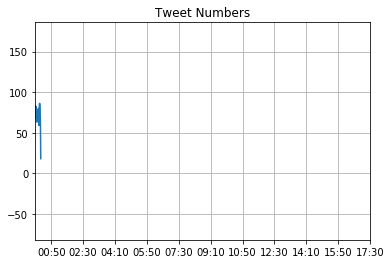

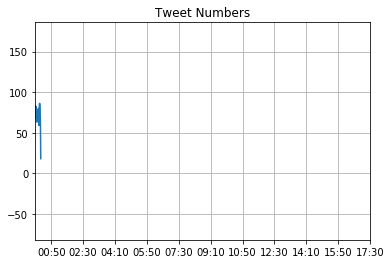

In [26]:
# Commented out IPython magic to ensure Python compatibility.
# The following code is to manipulate the data, and then visualize it into a time series line chart using Matplotlib. 

# Plotting the series
# %matplotlib inline
fig, ax = plt.subplots()
ax.grid(True)
ax.set_title("Tweet Numbers")
interval = md.MinuteLocator(interval=100)
date_formatter = md.DateFormatter('%H:%M')

#Change number according to the data
datemin = dt.datetime(2020, 3, 12, 00, 00) 
datemax = dt.datetime(2020, 3, 12, 17, 30)


ax.xaxis.set_major_locator(interval) 
ax.xaxis.set_major_formatter(date_formatter) 
ax.set_xlim(datemin, datemax)
max_freq = per_minute.max()
min_freq = per_minute.min()
ax.set_ylim(min_freq-100, max_freq+100) 
ax.plot(per_minute.index, per_minute)
display(fig)

In [27]:
# Sum of confirmed cases around the world
coronadf = (spark.read.format("csv").options(header="true").load("train.csv"))
coronadf.show()

coronadf.groupBy("Country_Region").agg({'ConfirmedCases': 'sum'}).orderBy("sum(ConfirmedCases)", ascending = False).show()

coronadf.groupBy("Province_State").agg({'ConfirmedCases': 'sum'}).orderBy("sum(ConfirmedCases)", ascending = False).show()

coronadf.groupBy("Country_Region").agg({'Fatalities': 'sum'}).orderBy("sum(Fatalities)", ascending = False).show()

+---+--------------+--------------+----------+--------------+----------+
| Id|Province_State|Country_Region|      Date|ConfirmedCases|Fatalities|
+---+--------------+--------------+----------+--------------+----------+
|  1|          null|   Afghanistan|2020-01-22|           0.0|       0.0|
|  2|          null|   Afghanistan|2020-01-23|           0.0|       0.0|
|  3|          null|   Afghanistan|2020-01-24|           0.0|       0.0|
|  4|          null|   Afghanistan|2020-01-25|           0.0|       0.0|
|  5|          null|   Afghanistan|2020-01-26|           0.0|       0.0|
|  6|          null|   Afghanistan|2020-01-27|           0.0|       0.0|
|  7|          null|   Afghanistan|2020-01-28|           0.0|       0.0|
|  8|          null|   Afghanistan|2020-01-29|           0.0|       0.0|
|  9|          null|   Afghanistan|2020-01-30|           0.0|       0.0|
| 10|          null|   Afghanistan|2020-01-31|           0.0|       0.0|
| 11|          null|   Afghanistan|2020-02-01|     

In [28]:
# Plot the histogram of Fatalities case in each countries
# coronadf.groupby('Country_Region').count().select('count').rdd.flatMap(lambda x: x).histogram(10)

In [29]:
# Filtering to find only US and ordering by confirmed cases
coronadf2 = coronadf.filter("Country_Region == 'US'").groupBy("Province_State").agg({'ConfirmedCases': 'sum'}).orderBy("sum(ConfirmedCases)", ascending = False)
coronadf.filter("Country_Region == 'US'").groupBy("Province_State").agg({'ConfirmedCases': 'sum'}).orderBy("sum(ConfirmedCases)", ascending = False).show()


coronadf2 = coronadf2.withColumn('ConfirmedCases%', F.col('sum(ConfirmedCases)')/F.sum('sum(ConfirmedCases)').over(Window.partitionBy()))
coronadf2.orderBy('ConfirmedCases%', ascending=False).show()

+--------------+-------------------+
|Province_State|sum(ConfirmedCases)|
+--------------+-------------------+
|      New York|           979899.0|
|    New Jersey|           241681.0|
|    California|           111277.0|
|      Michigan|           101929.0|
| Massachusetts|            85622.0|
|       Florida|            83575.0|
|     Louisiana|            80077.0|
|    Washington|            79131.0|
|      Illinois|            78090.0|
|  Pennsylvania|            68278.0|
|         Texas|            50047.0|
|       Georgia|            49527.0|
|   Connecticut|            37780.0|
|      Colorado|            36339.0|
|     Tennessee|            29655.0|
|          Ohio|            28639.0|
|       Indiana|            27483.0|
|      Maryland|            22530.0|
|North Carolina|            20288.0|
|     Wisconsin|            19043.0|
+--------------+-------------------+
only showing top 20 rows

+--------------+-------------------+--------------------+
|Province_State|sum(Confirme

In [30]:
# Filtering to find only Fatalities rate in the US and ordering by Fatalities
coronadf3 = coronadf.filter("Country_Region == 'US'").groupBy("Province_State").agg({'Fatalities': 'sum'}).orderBy("sum(Fatalities)", ascending = False)
coronadf.filter("Country_Region == 'US'").groupBy("Province_State").agg({'Fatalities': 'sum'}).orderBy("sum(Fatalities)", ascending = False)
coronadf3.withColumn('Fatalities%', F.col('sum(Fatalities)')/F.sum('sum(Fatalities)').over(Window.partitionBy())).show()


+--------------+---------------+--------------------+
|Province_State|sum(Fatalities)|         Fatalities%|
+--------------+---------------+--------------------+
|      New York|        21296.0| 0.39549092799970287|
|    New Jersey|         4460.0| 0.08282726985718795|
|    Washington|         3631.0| 0.06743179750032499|
|      Michigan|         3329.0| 0.06182331420506249|
|     Louisiana|         2973.0| 0.05521198952587888|
|    California|         2372.0| 0.04405073634557171|
|       Georgia|         1525.0|0.028320983527401714|
|      Illinois|         1450.0|0.026928148271955728|
|       Florida|         1296.0|0.024068193214106637|
| Massachusetts|         1254.0|0.023288205471056884|
|   Connecticut|          960.0| 0.01782829126970862|
|  Pennsylvania|          818.0|0.015191189852730885|
|      Colorado|          793.0| 0.01472691143424889|
|         Texas|          770.0|0.014299775289245455|
|       Indiana|          729.0|0.013538358682934983|
|          Ohio|          67